In [1]:
using Pkg
pkg"activate ."

In [2]:
skip = false
if skip
    @warn("Skipping package installation")
else
    pkg"add NLPModels"
    pkg"add LinearOperators"
    pkg"add https://github.com/JuliaSmoothOptimizers/Krylov.jl"
    pkg"add JuMP#release-0.18"
    pkg"add CUTEst"
    pkg"add NLPModelsJuMP"
    pkg"add https://github.com/abelsiqueira/NLPModelsIpopt.jl#options"
    pkg"add CSV"
    pkg"add DataFrames"
    pkg"add https://github.com/tpapp/LaTeXTabulars.jl"
    pkg"add https://github.com/abelsiqueira/Optimize.jl#latex_table"
    pkg"add BenchmarkProfiles"
    pkg"add Optim"
    pkg"add Interact"
    pkg"add Plots"
    pkg"add GR"
end

┌ Warning: Skipping package installation
└ @ Main In[2]:3


In [3]:
pkg"status"

    Status `~/projetos/dominique/JuliaSmoothOptimizers/talk/Project.toml`
  [ecbce9bc] BenchmarkProfiles v0.2.0
  [336ed68f] CSV v0.4.3
  [1b53aba6] CUTEst v0.4.0
  [a93c6f00] DataFrames v0.17.0
  [28b8d3ca] GR v0.37.0
  [c601a237] Interact v0.9.0
  [4076af6c] JuMP v0.18.5+ #release-0.18 (https://github.com/JuliaOpt/JuMP.jl.git)
  [1c827bf3] Krylov v0.0.0 #master (https://github.com/JuliaSmoothOptimizers/Krylov.jl)
  [94d9927c] LaTeXTabulars v0.0.0 #master (https://github.com/tpapp/LaTeXTabulars.jl)
  [5c8ed15e] LinearOperators v0.5.1
  [a4795742] NLPModels v0.7.0
  [bd118512] NLPModelsIpopt v0.1.0 #options (https://github.com/abelsiqueira/NLPModelsIpopt.jl)
  [792afdf1] NLPModelsJuMP v0.1.1
  [429524aa] Optim v0.17.2
  [5e8c6d2d] Optimize v0.0.0 #latex_table (https://github.com/abelsiqueira/Optimize.jl)
  [91a5bcdd] Plots v0.23.0


# JuliaSmoothOptimizers

## Packages for Continuous Nonlinear Optimization in Julia

**Abel Soares Siqueira**

Federal University of Paraná, Curitiba/PR, Brazil

**Dominique Orban**

GERAD/École Polytechnique de Montréal, Montreal/QC, Canada

![](jsologo.png)

**What is?**

- Linear Algebra and Optimization tools for developers/researches/academics;
- Created from our demands;
- Integrates with MPB/JuMP;
- We also develop solvers, focusing on large-scale;
- Similar work done previously in PythonOptimizers.

![](JSO-network.png)

**What it doesn't have**

- Integer programming;
- Linear programming - it could have an interior-point method;
- It's own modelling language;
- Complete replacement to Optim - yet.

# NLPModels

- Defines nonlinear programming models and unified API to access them;
- Some models provide sparse derivatives;
- Some models provide matrix-free products (i.e. no explicit matrix used);
- Creating a new model type is easy.

In [4]:
using NLPModels

# ADNLPModel uses ForwardDiff
adnlp = ADNLPModel(x -> (x[1] - 1)^2 + 100 * (x[2] - x[1]^2)^2, [-1.2; 1.0])

# CUTEst is a famous library. ROSENBR is the same problem
using CUTEst
cnlp = CUTEstModel("ROSENBR")

using JuMP, NLPModelsJuMP
m = Model()
@variable(m, x[1:2])
setvalue(x, [-1.2; 1.0])
@NLobjective(m, Min, (x[1] - 1)^2 + 100 * (x[2] - x[1]^2)^2)

mpnlp = MathProgNLPModel(m)

for (name, nlp) in [("Autodiff", adnlp),
                    ("CUTEst", cnlp),
                    ("JuMP", mpnlp)]
    x = nlp.meta.x0
    println("Model $name")
    println("fx = ", obj(nlp, x))
    println("gx = ", grad(nlp, x))
    println("Hx = ", hess(nlp, x))
end
finalize(cnlp)

┌ Info: Recompiling stale cache file /home/abel/.julia/compiled/v1.1/NLPModels/BL2h9.ji for NLPModels [a4795742-8479-5a88-8948-cc11e1c8c1a6]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/abel/.julia/compiled/v1.1/CUTEst/tNzSS.ji for CUTEst [1b53aba6-35b6-5f92-a507-53c67d53f819]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/abel/.julia/compiled/v1.1/JuMP/DmXqY.ji for JuMP [4076af6c-e467-56ae-b986-b466b2749572]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/abel/.julia/compiled/v1.1/NLPModelsJuMP/OX2CU.ji for NLPModelsJuMP [792afdf1-32c1-5681-94e0-d7bf7a5df49e]
└ @ Base loading.jl:1184


Model Autodiff
fx = 24.199999999999996
gx = [-215.6, -88.0]
Hx = [1330.0 0.0; 480.0 200.0]
Model CUTEst
fx = 24.199999999999996
gx = [-215.6, -88.0]
Hx = 
  [1, 1]  =  1330.0
  [2, 1]  =  480.0
  [2, 2]  =  200.0
Model JuMP
fx = 24.199999999999996
gx = [-215.6, -88.0]
Hx = 
  [1, 1]  =  1330.0
  [2, 1]  =  480.0
  [2, 2]  =  200.0


**Modified Newton method**

- Find $\rho_k \geq 0$ such that $\nabla^2 f(x_k) + \rho_k I$ is positive definite
- Find $d_k$ solution of $$\big(\nabla^2 f(x_k) + \rho_k I\big) d = -\nabla f(x_k); $$
- Find $\alpha_k > 0$ through backtracking such that
$$ f(x_k + \alpha_k d_k) \leq f(x_k) + \alpha_k \gamma \nabla f(x_k)^T d_k. $$

In [5]:
using LinearAlgebra

function newton(nlp :: AbstractNLPModel;  # Any model
                x :: AbstractVector = copy(nlp.meta.x0),
                atol :: Real = 1e-6,
                rtol :: Real = 1e-6,
                max_f :: Int = 1000,
                max_time :: Real = 30.0,
                )
    Δt = 0.0
    start_time = time()
    
    T = eltype(x)
    λmin = sqrt(eps(T))
    fx = obj(nlp, x)
    gx = zeros(nlp.meta.nvar)
    grad!(nlp, x, gx)
    
    normgx = norm(gx)
    ϵ = atol + rtol * normgx
    
    solved = normgx < ϵ # Boolean variable
    tired = sum_counters(nlp) > max_f || Δt > max_time
    
    while !(solved || tired)
        Hx = Symmetric(hess(nlp, x), :L) # Declare as a Symmetric matrix
        λ = 0.0
        G = cholesky(Hx, check=false)
        while !issuccess(G)
            λ = max(λmin, 10λ)
            G = cholesky(Hx + λ*I, check=false)
        end
        d = -(G \ gx)
        slope = dot(gx, d)
        t = one(T)
        xt = x + t * d
        ft = obj(nlp, xt)
        while !(ft ≤ fx + 1e-4 * t * slope)
            t /= 4
            xt = x + t * d
            ft = obj(nlp, xt)
        end
        
        x .= xt
        fx = ft
        grad!(nlp, x, gx)
        normgx = norm(gx)
        
        Δt = time() - start_time
        solved = normgx < ϵ
        tired = sum_counters(nlp) > max_f || Δt > max_time
    end
    
    return x, fx, normgx, Δt, neval_obj(nlp), neval_grad(nlp),
            neval_hess(nlp)
end

newton (generic function with 1 method)

In [6]:
using Printf

cnlp = CUTEstModel("ROSENBR") # finalized before

@printf("%10s  %8s  %8s  %4s  %4s  %4s\n",
        "f(x)", "‖∇f(x)‖", "Δt", "#f", "#g", "#H")
for nlp in [adnlp; cnlp; mpnlp]
    reset!(nlp) # reset counters
    x, fx, ngx, Δt, nf, ng, nH = newton(nlp)
    @printf("%+10.4f  %8.2e  %8.2e  %4d  %4d  %4d\n",
            fx, ngx, Δt, nf, ng, nH)
end

finalize(cnlp)

      f(x)   ‖∇f(x)‖        Δt    #f    #g    #H
   +0.0000  3.38e-05  6.83e-01    28    22    21
   +0.0000  3.38e-05  4.83e-02    28    22    21
   +0.0000  3.38e-05  3.82e-04    28    22    21


- `ADNLPModel` is quick and dirty: uses `ForwardDiff` which as dense matrices, but is easy to write small problems;
- `JuMP/MPB` is a complete modelling language, which you can use to define your own larger problem;
- `CUTEst` is traditionally used for benchmarking, so is needed for publications.

**Framework**

- IDEA!
- Prototype, test with `ADNLPModel`s;
- Test with `CUTEst`, compare, improve and repeat;
- Show aplication, implement with JuMP, run with same code.

**Other models**

- There are other models: Ampl, QPS, for quadratic problems, for slack variables;
- Creating a new one is not hard;
- There is more to the API, the problem considered is
$$ \min \ f(x) \qquad \text{subject to} \quad
\begin{array}{l}
c_L \leq c(x) \leq c_U \\
\ell \leq x \leq u;
\end{array}
$$
- There are tool to access $f$, $\nabla f$, $c$, $J_c(x)$, $\nabla_{xx}^2 L(x,y)$, where $L(x,y) = f(x) + y^Tc(x)$, etc;
- Other things are stores in `nlp.meta`: $c_L$, $c_U$, $\ell$, $u$, etc.

In [7]:
nlp = ADNLPModel(x -> sum(x.^4), ones(4),
                lvar=[-1; -Inf; 0; 0], uvar=[1; 0; Inf; 0],
                c=x->[sum(x); prod(x)], lcon=[1.0; 1.0], ucon=[1.0; Inf])

meta = nlp.meta
x = meta.x0
l, u = meta.lvar, meta.uvar
cl, cu = meta.lcon, meta.ucon
vartypes = meta.ifix, meta.ifree, meta.ilow, meta.iupp, meta.irng
contypes = meta.jfix, meta.jfree, meta.jlow, meta.jupp, meta.jrng

([1], Int64[], [2], Int64[], Int64[])

**Using Ipopt**

In [8]:
using Ipopt, MathProgBase

nlp = ADNLPModel(x -> sum(i * x[i]^4 for i = 1:4), ones(4),
                 c=x->[sum(x) - 1], lcon=[0.0], ucon=[0.0])
model = NLPtoMPB(nlp, IpoptSolver(print_level=0))
MathProgBase.optimize!(model)
x = MathProgBase.getsolution(model)

┌ Info: Recompiling stale cache file /home/abel/.julia/compiled/v1.1/Ipopt/yMQMo.ji for Ipopt [b6b21f68-93f8-5de0-b562-5493be1d77c9]
└ @ Base loading.jl:1184



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



4-element Array{Float64,1}:
 0.3208190046327305 
 0.25463421268677305
 0.22244347384216182
 0.20210330883833474

In [9]:
using NLPModelsIpopt

# Output will change
x, fx, cx, λ, zL, zU, status = ipopt(nlp, print_level=0)
x

┌ Info: Recompiling stale cache file /home/abel/.julia/compiled/v1.1/NLPModelsIpopt/qkIOE.ji for NLPModelsIpopt [bd118512-1daa-11e9-383d-afcd643cf987]
└ @ Base loading.jl:1184


4-element Array{Float64,1}:
 0.3208190046327305 
 0.25463421268677305
 0.22244347384216182
 0.20210330883833474

**Extension: Nonlinear least squares**

- Objective: $f(x) = \tfrac{1}{2}\|F(x)\|^2$;
- Knowing $F$ directly gives more power to the solver;
- `AbstractNLSModel <: AbstractNLPModel`
- `LLSModel(A, b)`: $F(x) = Ax - b$;
- `ADNLSModel(F, x0, ne)`;
- `MathProgNLSModel` - Uses traditional JuMP!

┌ Info: Recompiling stale cache file /home/abel/.julia/compiled/v1.1/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1184


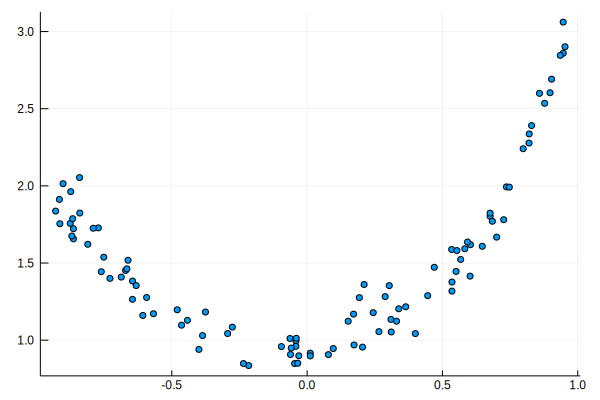

In [10]:
using Plots, Random
gr(size=(600,400))
Random.seed!(0)

N = 100
x = -1 .+ 2 * rand(N)
y = exp.(x.^2 + 0.2x) .+ randn(N) * 0.1
scatter(x, y, leg=false, ms=3)

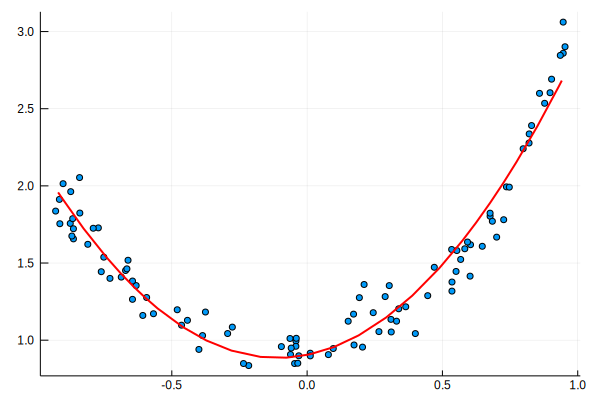

In [11]:
# y ~ β₀ + β₁x + β₂x²
X = [ones(N) x x.^2]
lls = LLSModel(X, y)
β, ssr, Xtr = newton(lls) # non-specialized solver
h(x) = β[1] + β[2] * x + β[3] * x^2
scatter(x, y, leg=false, ms=3)
plot!(h, extrema(x)..., c=:red, lw=2)

**Linear least-squares? Try CGLS**

In [12]:
using Krylov

β, stats = cgls(X, y)

┌ Info: Recompiling stale cache file /home/abel/.julia/compiled/v1.1/Krylov/uN9Vk.ji for Krylov [1c827bf3-6eee-5ba2-a791-0d0e96b78c23]
└ @ Base loading.jl:1184


([0.904324, 0.355016, 1.63022], 
Simple stats
  solved: true
  inconsistent: false
  residuals:  [  1.6e+01  3.5e+00  2.5e+00  1.3e+00 ]
  Aresiduals: [  1.7e+02  1.1e+01  8.0e+00  3.6e-13 ]
  status: solution good enough given atol and rtol
)

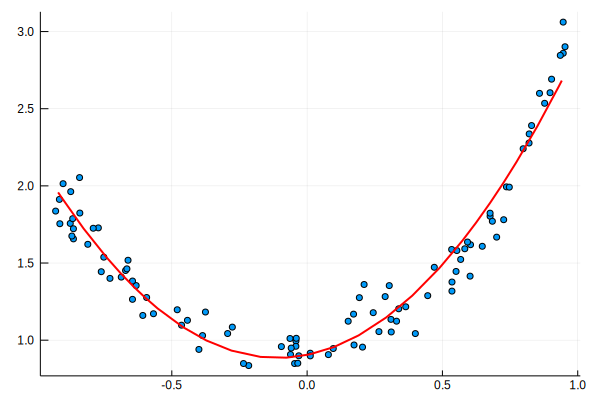

In [13]:
h(x) = β[1] + β[2] * x + β[3] * x^2
scatter(x, y, leg=false, ms=3)
plot!(h, extrema(x)..., c=:red, lw=2)

**More LS methods in Krylov: cgls, crls, lslq, lsmr, lsqr**

- See references;

**Linear least squares with regularization**

$$ \min \tfrac{1}{2}\|Ax - b\|^2 + \lambda\tfrac{1}{2}\|x\|^2. $$

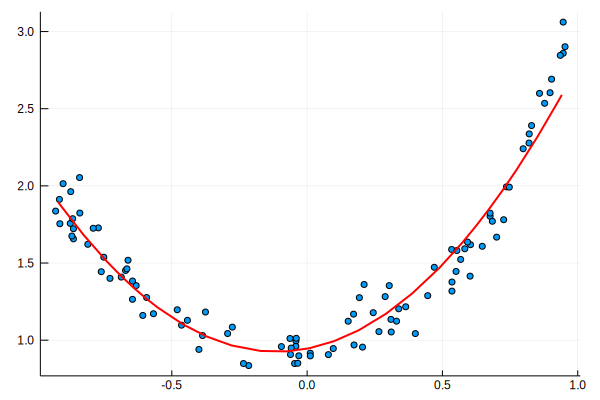

In [14]:
λ = 1.0
β, stats = lslq(X, y, λ=λ)
h(x) = β[1] + β[2] * x + β[3] * x^2
scatter(x, y, leg=false, ms=3)
plot!(h, extrema(x)..., c=:red, lw=2)

In [15]:
using Interact

@manipulate for λ = 2.0 .^ (-5:0.5:5)
    β, stats = lslq(X, y, λ=λ)
    h(x) = β[1] + β[2] * x + β[3] * x^2
    scatter(x, y, leg=false, ms=3)
    plot!(h, extrema(x)..., c=:red, lw=2)
end

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/e3e959aab0ff6faa1f914a2ea6e93590593d2195-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/e3e959aab0ff6faa1f914a2ea6e93590593d2195-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

Widget{:manipulate,Any}(OrderedDict{Symbol,Any}(:λ=>Widget{:slider,Float64}(OrderedDict{Symbol,Any}(:changes=>Observable{Int64} with 1 listeners. Value:
0,:index=>Observable{Any} with 2 listeners. Value:
11,:formatted_vals=>Observable{Any} with 1 listeners. Value:
["0.03125", "0.0441942", "0.0625", "0.0883883", "0.125", "0.176777", "0.25", "0.353553", "0.5", "0.707107"  …  "1.41421", "2.0", "2.82843", "4.0", "5.65685", "8.0", "11.3137", "16.0", "22.6274", "32.0"],:formatted_value=>Observable{String} with 1 listeners. Value:
"1.0",:value=>Observable{Float64} with 2 listeners. Value:
1.0), Observable{Float64} with 2 listeners. Value:
1.0, Scope("knockout-component-a8f08e2a-5e1d-476f-a63f-74db14dfc66b", Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any["λ"], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")), 1)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-left")), 2), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :input), Any[], Dict{Symbol,Any}(:max=>21,:min=>1,:attributes=>Dict{Any,Any}(:type=>"range",Symbol("data-bind")=>"numericValue: index, valueUpdate: 'input', event: {change : function () {this.changes(this.changes()+1)}}","orient"=>"horizontal"),:step=>1,:className=>"slider slider is-fullwidth",:style=>Dict{Any,Any}()), 0)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-center")), 1), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text: formatted_value")), 0)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-right")), 1)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row")), 7), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("formatted_vals"=>(Observable{Any} with 1 listeners. Value:
["0.03125", "0.0441942", "0.0625", "0.0883883", "0.125", "0.176777", "0.25", "0.353553", "0.5", "0.707107"  …  "1.41421", "2.0", "2.82843", "4.0", "5.65685", "8.0", "11.3137", "16.0", "22.6274", "32.0"], nothing),"changes"=>(Observable{Int64} with 1 listeners. Value:
0, nothing),"formatted_value"=>(Observable{String} with 1 listeners. Value:
"1.0", nothing),"index"=>(Observable{Any} with 2 listeners. Value:
11, nothing)), Set(String[]), nothing, Any["knockout"=>"/home/abel/.julia/packages/Knockout/JIqpG/src/../assets/knockout.js", "knockout_punches"=>"/home/abel/.julia/packages/Knockout/JIqpG/src/../assets/knockout_punches.js", "/home/abel/.julia/packages/InteractBase/3SqBl/src/../assets/all.js", "/home/abel/.julia/packages/InteractBase/3SqBl/src/../assets/style.css", "/home/abel/.julia/packages/InteractBulma/Ohu5Y/src/../assets/main.css"], Dict{Any,Any}("formatted_vals"=>Any[JSString("(function (val){return (val!=this.model[\"formatted_vals\"]()) ? (this.valueFromJulia[\"formatted_vals\"]=true, this.model[\"formatted_vals\"](val)) : undefined})")],"_promises"=>Dict{Any,Any}("importsLoaded"=>Any[JSString("function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init : function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            })\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            })\n            ko.applyBindingsToNode(element, { value: stringified, valueUpdate: allBindings.get('valueUpdate')}, context);\n        }\n    };\n    var json_data = JSON.parse(\"

**Nonlinear least squares**

┌ Info: Recompiling stale cache file /home/abel/.julia/compiled/v1.1/CSV/HHBkp.ji for CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1184


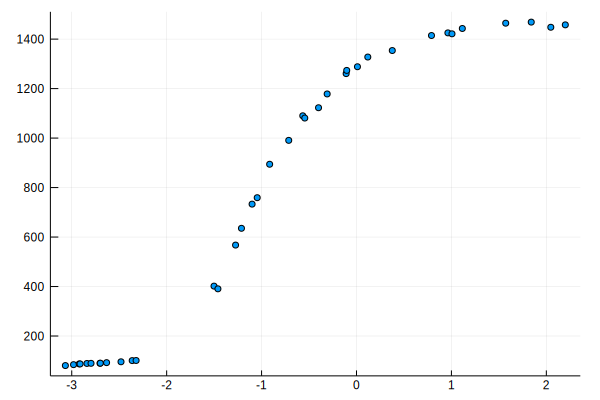

In [16]:
using CSV, DataFrames

# https://www.itl.nist.gov/div898/strd/nls/nls_main.shtml
df = CSV.read("thurber.csv")
x, y = df.x, df.y
scatter(x, y, ms=3, leg=false)

- Model $h(\beta; x)$;
- Residual $r(\beta) = [h(\beta; x_i) - y_i]_{i=1,\dots,N}$;
- Solve $$\min_{\beta} \tfrac{1}{2}\|r(\beta)\|^2. $$

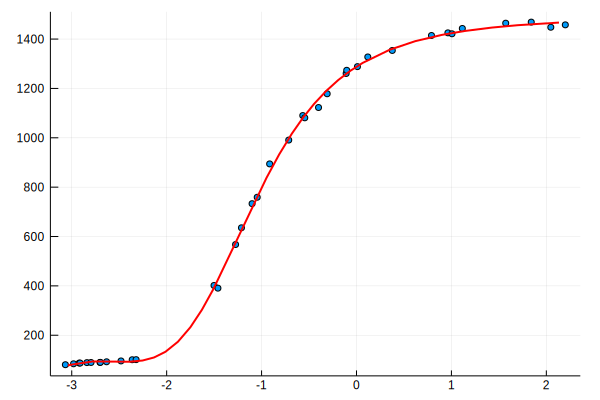

In [17]:
# y ~ (β₁ + β₂x + β₃x² + β₄x³) / (1 + β₅x + β₆x² + β₇x³)
h(β, xi) = (β[1] + β[2] * xi + β[3] * xi^2 +
    β[4] * xi^3) / (1 + β[5] * xi + β[6] * xi^2 + β[7] * xi^3)
r(β) = [h(β, x[i]) - y[i] for i = 1:N]
N = length(x)
nls = ADNLSModel(r, ones(7), N)
β, ssr, Jtr, Δt = newton(nls) # non-specialized solver

scatter(x, y, leg=false, ms=3)
plot!(x->h(β,x), extrema(x)..., c=:red, lw=2)

**Creating a NLS with JuMP**

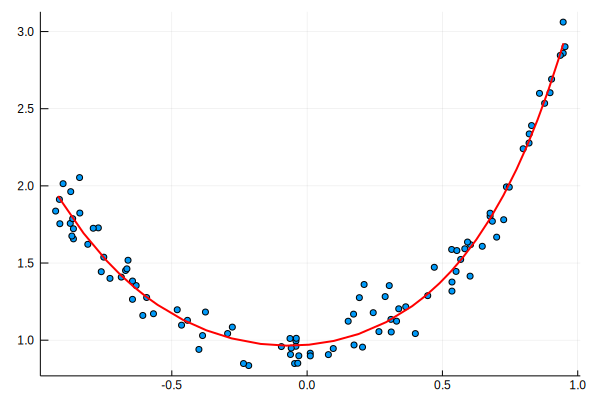

In [18]:
Random.seed!(0)

N = 100
x = -1 .+ 2 * rand(N)
y = exp.(x.^2 + 0.2x) .+ randn(N) * 0.1

# y ~ β₀ + β₁ sinh(β₂ x) + β₃ cosh(β₄ x)
model = Model()
@variable(model, β[1:5], start=1.0)
@NLexpression(model, F[i=1:N], β[1] + β[2] * sinh(β[3] * x[i])
    + β[4] * cosh(β[5] * x[i]) - y[i])
nls = MathProgNLSModel(model, F)
β, ssr, Jtr, Δt = newton(nls)

h(x) = β[1] + β[2] * sinh(β[3] * x) + β[4] * cosh(β[5] * x)
scatter(x, y, leg=false, ms=3)
plot!(x->β[1] + β[2] * sinh(β[3] * x) + β[4] * cosh(β[5] * x),
    extrema(x)..., c=:red, lw=2)

**Modifying models**
- Beyond having models to create problems, we have models to modify them;
- `SlackModel` transforms inequalities in equalities with bounds:
$$ \min_x \ f(x) \ \text{s.to} \ c(x) \geq 0
\quad \Rightarrow \quad
\min_{x,s} \ f(x) \ \text{s.to} \ c(x) - s = 0, \ s \geq 0;
$$
- `FeasibilityResidual` takes the constraints of a problem and constructs a NLS:
$$ \min_x \ f(x) \ \text{s.t.} \ c(x) = 0
\quad \Rightarrow \quad
\min_x \ \tfrac{1}{2}\|c(x)\|^2;
$$
- `FeasibilityFormNLS` puts the residual function in the constraints, providing a better problem for general solvers;
$$ \min_x \ \tfrac{1}{2}\|F(x)\|^2
\quad \Rightarrow \quad
\min_{x,r} \ \tfrac{1}{2}\|r\|^2 \ \text{s.to} \ F(x) - r = 0.$$
- Other modifications are planned.

**More models**

- `CUTEst.jl` provides access to all of 1305 `CUTEst` problems, with both the `CUTEst` API and the `NLPModels` API. Contains a tool for selecting problems;
- `AmplNLReader.jl` provides access to problems written in the Ampl modelling language;
- `OptimizationProblems.jl` stores NLP problems in JuMP format. Some problems from CUTEst are implemented. More are welcome;
- `NLSProblems.jl` stores NLS problems. Moré-Garbow-Hillstrom and some other models are implemented. More are welcome;
- Problem: No way to classify and select problems from these last two yet. `abelsiqueira/NLPClass.jl` was an attempt.

## Optimize

- Tools for line search and trust region methods;
- Benchmark solvers, return DataFrames;
- Optimization methods;

In [21]:
using Optimize, BenchmarkProfiles, Logging

pnames = CUTEst.select(max_var=2, contype=:unc)
problems = (CUTEstModel(p) for p in pnames)
solvers = Dict{Symbol,Function}(:lbfgs => lbfgs, :trunk => trunk)
stats = bmark_solvers(solvers, problems)

Dict{Symbol,DataFrame} with 2 entries:
  :trunk => 37×29 DataFrame. Omitted printing of 22 columns…
  :lbfgs => 37×29 DataFrame. Omitted printing of 22 columns…

In [23]:
df = stats[:trunk]

37×29 DataFrame. Omitted printing of 22 columns
│ Row │ id    │ name       │ nvar  │ ncon  │ nequ  │ status      │ objective   │
│     │ Int64 │ String     │ Int64 │ Int64 │ Int64 │ Symbol      │ Float64     │
├─────┼───────┼────────────┼───────┼───────┼───────┼─────────────┼─────────────┤
│ 1   │ 1     │ HILBERTA   │ 2     │ 0     │ 0     │ first_order │ 2.05433e-33 │
│ 2   │ 2     │ BOXBODLS   │ 2     │ 0     │ 0     │ first_order │ 1168.01     │
│ 3   │ 3     │ HIMMELBB   │ 2     │ 0     │ 0     │ first_order │ 3.03002e-8  │
│ 4   │ 4     │ SISSER     │ 2     │ 0     │ 0     │ first_order │ 1.15471e-8  │
│ 5   │ 5     │ SINEVAL    │ 2     │ 0     │ 0     │ first_order │ 7.39034e-36 │
│ 6   │ 6     │ MISRA1ALS  │ 2     │ 0     │ 0     │ first_order │ 19.5159     │
│ 7   │ 7     │ HAIRY      │ 2     │ 0     │ 0     │ first_order │ 20.0        │
│ 8   │ 8     │ MARATOSB   │ 2     │ 0     │ 0     │ first_order │ 0.995893    │
│ 9   │ 9     │ POWELLBSLS │ 2     │ 0     │ 0     │ first_order │ 0.00671971  │
│ 10  │ 10    │ HIMMELBG   │ 2     │ 0     │ 0     │ first_order │ 1.5326e-14  │
⋮
│ 27  │ 27    │ MEXHAT     │ 2     │ 0     │ 0     │ first_order │ -0.03232    │
│ 28  │ 28    │ DENSCHNB   │ 2     │ 0     │ 0     │ first_order │ 4.57357e-23 │
│ 29  │ 29    │ BROWNBS    │ 2     │ 0     │ 0     │ first_order │ 0.0         │
│ 30  │ 30    │ DANWOODLS  │ 2     │ 0     │ 0     │ first_order │ 0.00431731  │
│ 31  │ 31    │ AKIVA      │ 2     │ 0     │ 0     │ first_order │ 6.16604     │
│ 32  │ 32    │ ROSENBR    │ 2     │ 0     │ 0     │ first_order │ 5.17018e-8  │
│ 33  │ 33    │ HUMPS      │ 2     │ 0     │ 0     │ max_eval    │ 5.9183      │
│ 34  │ 34    │ MISRA1CLS  │ 2     │ 0     │ 0     │ first_order │ 4.74512     │
│ 35  │ 35    │ CLIFF      │ 2     │ 0     │ 0     │ first_order │ 403.159     │
│ 36  │ 36    │ LOGHAIRY   │ 2     │ 0     │ 0     │ max_eval    │ 4.38449     │
│ 37  │ 37    │ CUBE       │ 2     │ 0     │ 0     │ first_order │ 6.43309e-9  │

In [30]:
first(df[[:name, :status, :elapsed_time, :objective, :neval_obj]], 6)

6×5 DataFrame
│ Row │ name      │ status      │ elapsed_time │ objective   │ neval_obj │
│     │ String    │ Symbol      │ Float64      │ Float64     │ Int64     │
├─────┼───────────┼─────────────┼──────────────┼─────────────┼───────────┤
│ 1   │ HILBERTA  │ first_order │ 0.000127077  │ 2.05433e-33 │ 5         │
│ 2   │ BOXBODLS  │ first_order │ 0.000930071  │ 1168.01     │ 44        │
│ 3   │ HIMMELBB  │ first_order │ 0.000533104  │ 3.03002e-8  │ 26        │
│ 4   │ SISSER    │ first_order │ 0.000267029  │ 1.15471e-8  │ 13        │
│ 5   │ SINEVAL   │ first_order │ 0.00112796   │ 7.39034e-36 │ 163       │
│ 6   │ MISRA1ALS │ first_order │ 0.00022912   │ 19.5159     │ 4         │

In [35]:
latex_tabular_results(stdout, df, cols=[:name, :status, :elapsed_time, :objective, :neval_obj],
    format_over=Dict{Symbol,Function}(:name => x -> @sprintf("%-10s", x),
                                      :status => x -> @sprintf("%11s", x))
)

\begin{longtable}[c]{lrrrr}
\hline 
Name & status & elapsed_time & $f(x)$ & neval_obj \\
\hline 
\endfirsthead
\multicolumn{5}{l}
{{\bfseries \tablename\ \thetable{} --- continued from previous page}} \\
\hline 
Name & status & elapsed_time & $f(x)$ & neval_obj \\
\hline 
\endhead
\hline 
\multicolumn{5}{r}{{\bfseries Continued on next page}} \\
\hline 
\endfoot
\hline 
\endlastfoot
HILBERTA   & first_order & \(1.3\)e\(-04\) & \(2.1\)e\(-33\) & \(    5\) \\
BOXBODLS   & first_order & \(9.3\)e\(-04\) & \(1.2\)e\(+03\) & \(   44\) \\
HIMMELBB   & first_order & \(5.3\)e\(-04\) & \(3.0\)e\(-08\) & \(   26\) \\
SISSER     & first_order & \(2.7\)e\(-04\) & \(1.2\)e\(-08\) & \(   13\) \\
SINEVAL    & first_order & \(1.1\)e\(-03\) & \(7.4\)e\(-36\) & \(  163\) \\
MISRA1ALS  & first_order & \(2.3\)e\(-04\) & \(2.0\)e\(+01\) & \(    4\) \\
HAIRY      & first_order & \(2.0\)e\(-03\) & \(2.0\)e\(+01\) & \(  140\) \\
MARATOSB   & first_order & \(2.2\)e\(-04\) & \(1.0\)e\(+00\) & \(    4\) \\
POWELL

In [36]:
P = hcat([sdf.elapsed_time + (sdf.status .!= :first_order) * Inf for (name,sdf) in stats]...)

37×2 Array{Float64,2}:
   0.000127077    0.000163078
   0.000930071    0.000140905
   0.000533104    0.00020504 
   0.000267029    0.000385046
   0.00112796     0.00101805 
   0.00022912     0.000347137
   0.00198102     0.000696898
   0.000221968    0.000176191
   0.000346184    0.00240707 
   0.000222921    0.000334024
   0.000159025    0.000540972
   0.000137091    0.000369072
   0.000135899    0.000156879
   ⋮                         
   0.000252008    0.000478029
   0.000418901    0.000388861
   0.000169992    0.000257969
   0.000785828    0.000244856
   0.000328064    0.000513792
   0.00124812   Inf          
   0.000661135    0.000577927
 Inf              0.00258279 
   0.000197172    0.000304937
   0.000283957    0.000127077
 Inf              0.00153708 
   0.000939131    0.00067687 

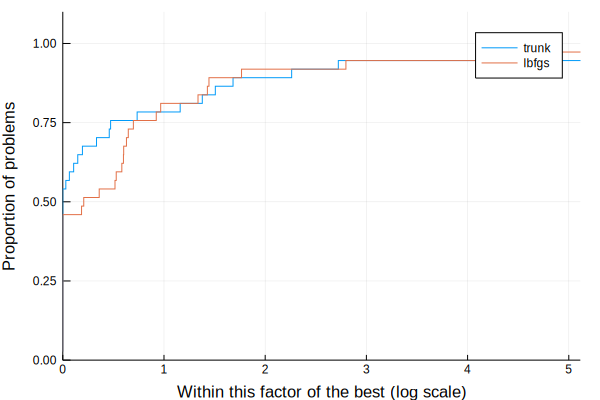

In [37]:
performance_profile(P, string.(keys(stats)))

In [38]:
using Optim

function optim_method(nlp :: AbstractNLPModel; kwargs...)
    f(x) = obj(nlp, x)
    g!(storage, x) = grad!(nlp, x, storage)
    Δt = time()
    output = optimize(f, g!, nlp.meta.x0, LBFGS(m = 5),
                    Optim.Options(g_tol=1e-8,
                                  iterations=10_000_000,
                                  f_calls_limit = 10_000))
    Δt = time() - Δt
    status = output.g_converged ? :first_order : :unknown
    return GenericExecutionStats(status, nlp, solution=output.minimizer,
                objective=output.minimum, dual_feas=output.g_residual,
                iter=output.iterations, elapsed_time=Δt)
end

┌ Info: Recompiling stale cache file /home/abel/.julia/compiled/v1.1/Optim/R5uoh.ji for Optim [429524aa-4258-5aef-a3af-852621145aeb]
└ @ Base loading.jl:1184


optim_method (generic function with 1 method)

In [39]:
pnames = CUTEst.select(max_var=2, contype=:unc)
problems = (CUTEstModel(p) for p in pnames)
solvers = Dict{Symbol,Function}(:JSO => lbfgs, :Optim => optim_method)
stats = with_logger(NullLogger()) do
    bmark_solvers(solvers, problems)
end

Dict{Symbol,DataFrame} with 2 entries:
  :JSO   => 37×29 DataFrame. Omitted printing of 22 columns…
  :Optim => 37×29 DataFrame. Omitted printing of 22 columns…

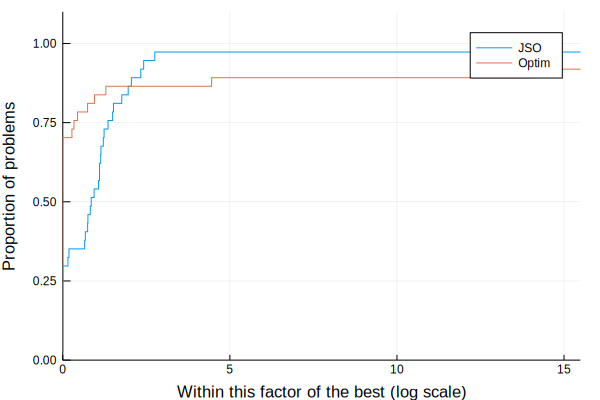

In [40]:
P = hcat([sdf.elapsed_time + (sdf.status .!= :first_order) * Inf for (name,sdf) in stats]...)
performance_profile(P, string.(keys(stats)))

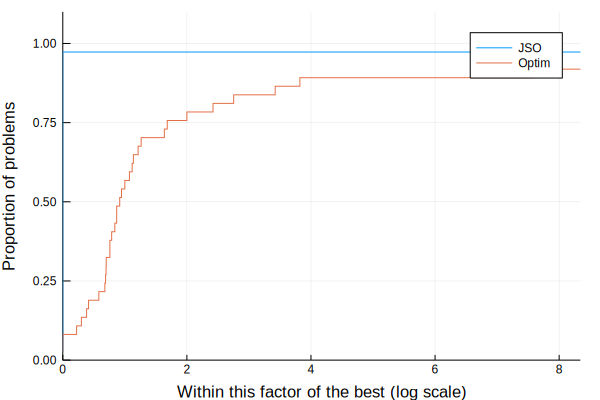

In [41]:
P = hcat([sdf.neval_obj + sdf.neval_grad + (sdf.status .!= :first_order) * Inf for (name,sdf) in stats]...)
performance_profile(P, string.(keys(stats)))

## Present and future

**Multiprecision support across many packages**

In [42]:
nlp = ADNLPModel(x -> (x[1] - 1)^2 + 100 * (x[2] - x[1]^2)^2, [-1.2; 1.0])

ADNLPModel(Minimization problem Generic
nvar = 2, ncon = 0 (0 linear)
, Counters(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), getfield(Main, Symbol("##48#49"))(), getfield(NLPModels, Symbol("##117#120"))())

In [56]:
reset!(nlp); output = newton(nlp, x=[-1.2; 1.0])

([1.0, 1.0], 5.848890700604937e-13, 3.3758147933432036e-5, 0.0002770423889160156, 28, 22, 21)

In [57]:
reset!(nlp); output = newton(nlp, x=Float32[-1.2; 1.0])

(Float32[1.0, 1.0], 8.403910713076168e-13, 2.6442971158120422e-5, 0.00026988983154296875, 28, 22, 21)

In [54]:
reset!(nlp); output = newton(nlp, x=Float16[-1.2; 1.0])

(Float16[1.0, 1.0], 5.388525329597767e-9, 0.0, 0.00019693374633789062, 29, 22, 21)

In [55]:
reset!(nlp); output = newton(nlp, x=BigFloat[-1.2; 1.0], atol=1e-32, rtol=1e-32)

(BigFloat[1.0, 1.0], 1.888185320690136570279685486428472331045032884944912246058801876349560000324015e-76, 3.4145398681571716e-38, 0.0012860298156738281, 31, 25, 24)

- Float64 and Float32 are hardware natives and faster;
- Could be done in the GPU without much change.

**General solver**

In [58]:
using Optimize

nlp = ADNLPModel(x -> (x[1] - 1)^2 + 100 * (x[2] - x[1]^2)^2, [-1.2; 1.0])

ADNLPModel(Minimization problem Generic
nvar = 2, ncon = 0 (0 linear)
, Counters(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), getfield(Main, Symbol("##50#51"))(), getfield(NLPModels, Symbol("##117#120"))())

In [60]:
stats = trunk(nlp, logger=ConsoleLogger())
stats.solution, stats.objective, stats.status

[ Info: Iter          f     ‖∇f‖   Radius     Ratio  Inner  bk  status
[ Info:    0   2.42e+01  2.3e+02  2.3e+01   1.1e+00      2   0  solution good enough given atol and rtol
[ Info:    1   4.57e+00  3.1e+01  2.3e+01   1.0e+00      2   0  solution good enough given atol and rtol
[ Info:    2   4.13e+00  1.9e+00  2.3e+01  -9.8e+01      3  10  on trust-region boundary
[ Info:    3   4.13e+00  1.9e+00  1.3e+00   3.1e-01      3   3  on trust-region boundary
[ Info:    4   3.72e+00  3.4e+01  1.3e+00   1.0e+00      2   0  solution good enough given atol and rtol
[ Info:    5   2.78e+00  2.8e+00  1.3e+00   1.7e-01      3   5  on trust-region boundary
[ Info:    6   2.61e+00  2.3e+01  1.3e+00   1.0e+00      2   0  solution good enough given atol and rtol
[ Info:    7   1.73e+00  2.6e+00  1.3e+00   3.9e-01      3   8  on trust-region boundary
[ Info:    8   1.50e+00  1.3e+01  1.3e+00   1.2e+00      3   0  solution good enough given atol and rtol
[ Info:    9   9.73e-01  2.4e+00  1.3e+00   1.3e

([0.999773, 0.999545], 5.1701795850129765e-8, :first_order)

In [61]:
stats = lbfgs(nlp, logger=ConsoleLogger())
stats.solution, stats.objective, stats.status

[ Info: iter         f     ‖∇f‖      ∇f'd    bk
[ Info:    0   2.4e+01  2.3e+02  -5.4e+04     7
[ Info:    1   2.2e+01  1.6e+02  -2.6e+01     0
[ Info:    2   4.9e+00  4.1e+01  -2.1e+00     0
[ Info:    3   4.2e+00  1.1e+01  -1.3e-01     0
[ Info:    4   4.1e+00  1.9e+00  -3.2e-03     0
[ Info:    5   4.1e+00  1.8e+00  -4.2e-01     0
[ Info:    6   3.8e+00  1.7e+01  -1.7e-01     0
[ Info:    7   3.7e+00  1.9e+01  -8.0e-01     0
[ Info:    8   3.2e+00  2.2e+01  -7.3e-01     0
[ Info:    9   2.7e+00  7.9e+00  -7.7e-01     0
[ Info:   10   2.6e+00  2.2e+01  -1.2e+00     0
[ Info:   11   2.2e+00  3.0e+00  -2.5e-01     0
[ Info:   12   1.9e+00  4.3e+00  -1.7e+00     2
[ Info:   13   1.7e+00  8.4e+00  -2.3e-01     0
[ Info:   14   1.6e+00  1.1e+01  -4.0e-01     0
[ Info:   15   1.3e+00  5.6e+00  -3.7e-01     0
[ Info:   16   1.1e+00  7.6e+00  -4.9e-01     0
[ Info:   17   7.8e-01  1.7e+00  -4.4e-01     1
[ Info:   18   6.7e-01  4.8e+00  -1.3e-01     0
[ Info:   19   5.7e-01  5.3e+00  -3.2e-0

([1.0, 1.0], 1.8247317610858418e-13, :first_order)

In [62]:
nlp = ADNLPModel(x -> (x[1] - 1)^2 + 100 * (x[2] - x[1]^2)^2, [-1.2; 1.0],
            lvar=[-Inf;-Inf], uvar=[0.5;Inf])

ADNLPModel(Minimization problem Generic
nvar = 2, ncon = 0 (0 linear)
, Counters(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), getfield(Main, Symbol("##54#55"))(), getfield(NLPModels, Symbol("##118#121"))())

In [64]:
stats = tron(nlp, logger=ConsoleLogger())
stats.solution, stats.objective, stats.status

[ Info: Iter          f        π   Radius    Ratio  CG-status
[ Info:    0   2.42e+01  8.8e+01  8.8e+00
[ Info:    1   4.58e+00  1.2e+01  8.8e+00  1.1e+00  stationary point found
[ Info:    2   3.86e+00  2.0e+00  1.7e-01  1.2e+00  stationary point found
[ Info:    3   3.37e+00  1.9e+00  2.5e-01  1.2e+00  on trust-region boundary
[ Info:    4   3.37e+00  1.9e+00  1.0e+00  -4.7e+00  on trust-region boundary
[ Info:    5   2.79e+00  1.1e+01  3.0e-01  6.0e-01  on trust-region boundary
[ Info:    6   2.13e+00  3.8e+00  6.6e-01  1.3e+00  stationary point found
[ Info:    7   2.13e+00  3.8e+00  6.6e-01  -1.8e-01  stationary point found
[ Info:    8   1.71e+00  3.5e+00  1.9e-01  1.2e+00  on trust-region boundary
[ Info:    9   1.71e+00  3.5e+00  4.6e-01  -4.7e-02  stationary point found
[ Info:   10   1.34e+00  3.5e+00  1.6e-01  1.2e+00  on trust-region boundary
[ Info:   11   1.24e+00  1.4e+01  3.8e-01  3.2e-01  stationary point found
[ Info:   12   6.82e-01  8.2e-01  1.6e-01  1.1e+00  statio

([0.5, 0.25], 0.25, :first_order)

- We have two good solvers for unconstrained problems;
- One good solver for bound-constrained problems;
- We are working on a new solver for nonlinear least squares with constraints;
- We plan to extend it to handle more general problems;
- Large-scale;

**NLPModels extension**

- $g(x) = \sum_{i=1}^N \sigma_i f_i(x) + \sigma_{NLS} \tfrac{1}{2}\|F(x)\|^2 + \sigma_{LS} \tfrac{1}{2}\|Ax - b\|^2$;
- It's a code refactoring, improving internal structure between NLPs and NLSs;
- It's also an extension, allowing separable functions $f_i$;
- You can ignore $g$ and look only at $f_i$ separately;
  - Sthocastic gradient;
  - Multiobjective problems;

**Parameter optimization**

- For the ML people: hyperparameter;
- Create your solver, pass the problems, get an optimized solver;
  - `opt_param = tune(solver, problems)`
  - `opt_solver = solver_with_parameters(solver, opt_param)`

**What we'd like**

- Feedback;
- Type stability;
- More solvers;
- More publications;
- Reach JSO 1.0.

**Publications**

- Dahito, M.-A., & Orban, D. (2018). The Conjugate Residual Method in Linesearch and Trust-Region Methods (Cahier du GERAD No. G-2018-50). Montréal, QC, Canada: GERAD. doi:10.13140/RG.2.2.24634.08649 
- Estrin, R., Orban, D., & Saunders, M. A. (2018). LNLQ: An Iterative Method for Least-Norm Problems with an Error Minimization Property (Cahier du GERAD No. G-2018-40). Montréal, QC, Canada: GERAD. doi:10.13140/RG.2.2.34725.81123 
- Buttari, A., Orban, D., Ruiz, D., & Titley-Peloquin, D. (2018). A Tridiagonalization Method for Symmetric Saddle-Point and Quasi-Definite System (Cahier du GERAD No. G-2018-42). Montréal, QC, Canada: GERAD. doi:10.13140/RG.2.2.26337.20328 
- Orban, D., & Arioli, M. (2017). Iterative Solution of Symmetric Quasi-Definite Linear Systems (Vol. 3). SIAM. doi:10.1137/1.9781611974737 
- Estrin, R., Orban, D., & Saunders, M. A. (2017). LSLQ: An Iterative Method for Linear Least-Squares with an Error Minimization Property. SIAM Journal On Matrix Analysis, v(n), p–q. doi:10.13140/RG.2.2.17818.64966

*In preparation*

- Siqueira, A. S., & Orban, D. A Regularization Method for Constrained Nonlinear Least Squares.
- Siqueira, A. S., & Orban, D. JuliaSmoothOptimizers.